## Spike detection for Amrita's data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
import pickle as pkl

In [2]:
from keras.models import load_model
from spikeDetectionNN.spikeDetector import prepare_sequences, create_lstm_model
from spikeDetectionNN.utils import detected_peak_spikes, plot_spks, plot_test_performance, print_spike_detection_report

Using TensorFlow backend.


## Train on an exemplary cell

In [3]:
folder = '/groups/svoboda/svobodalab/users/Amrita/STVoltron/402361/Annotated/'
cellId = 'Cell_12'

with open(folder + cellId + '_spikes.pkl', 'rb') as f:
    spk = pkl.load(f)
    voltr = -spk['dF_F']
    spkTime = spk['spike_frames_manual'].astype(int)
    spkcount = np.empty(voltr.shape)
    spkcount[:] = False
    spkcount[spkTime] = True

In [4]:
window_length = 40
x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.3
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]
x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

In [5]:
hidden_dim = 100
m = create_lstm_model(hidden_dim, window_length)
m.fit(x_train, y_train, batch_size=128, nb_epoch=5, validation_data=(x_test, y_test))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 164416 samples, validate on 70545 samples
Epoch 1/5
164416/164416 [==============================] - 301s 2ms/step - loss: 0.1834 - val_loss: 0.1359
Epoch 2/5
164416/164416 [==============================] - 275s 2ms/step - loss: 0.1336 - val_loss: 0.1290
Epoch 3/5
164416/164416 [==============================] - 267s 2ms/step - loss: 0.1269 - val_loss: 0.1304
Epoch 4/5
164416/164416 [==============================] - 255s 2ms/step - loss: 0.1189 - val_loss: 0.1131
Epoch 5/5
164416/164416 [==============================] - 255s 2ms/step - loss: 0.1079 - val_loss: 0.1030


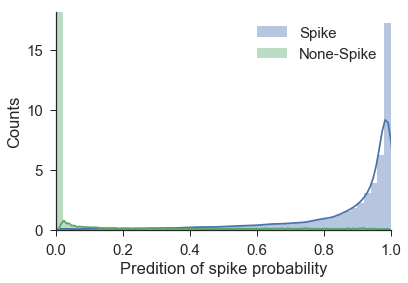

In [6]:
plot_test_performance(m, x_test, contain_outliers_[~train_test_index])

In [8]:
spk_ = detected_peak_spikes(m, x_, voltr, thres=0.4, devoltr_ = None)
spk = spkcount

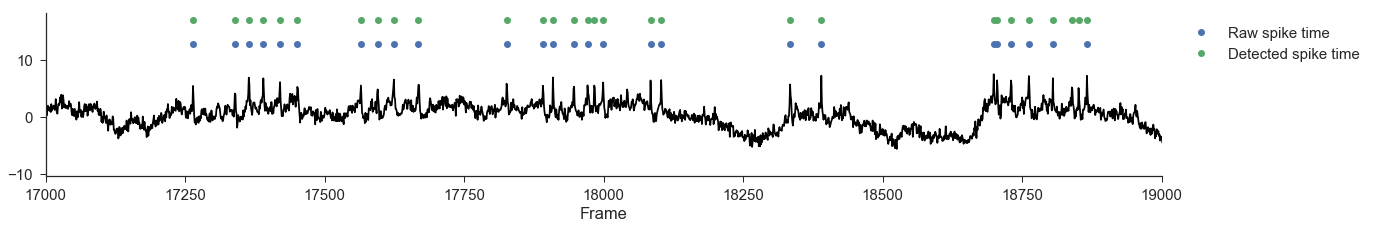

In [10]:
plt.figure(figsize=(20, 3))
plot_spks(plt, spk, voltr.max()*1.5, label='Raw spike time')
plot_spks(plt, spk_, voltr.max()*2.0, label='Detected spike time')
plt.plot(voltr,'-k')
plt.xlabel('Frame')
plt.xlim([17000, 19000])
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

In [11]:
print_spike_detection_report(spk, spk_, 'Result for Cell#12')

-------------------
Result for Cell#12
Total ephys spikes 1361
Total detected spikes 2019
Found spikes 1339
Unfound spikes 22
Extra spikes 680


## Train on all cells